# Network Usage Statistics by MAC
Get detatiled and fairly accurate usage statistics for every device on your network using the version of bwmon here: https://github.com/vortex-5/ddwrt-bwmon. This is a nice little collection of scripts that interrogates the network and saves necessary information in a simple way. I wanted to be able to see changes over time, so developed this quick and dirty python program and underlying manual process to keep things running. There is still a lot that I can do to automate this, most notably using another machine as the controller - probably a RPi as it used to be before being repurposed for ADSB. 

The README.md file has more information on the hardware, but I am using a Buffalo router running DD-WRT that does not have permamanent memory. So if the router goes down there is a process to reload and restart the process. ORiginally, this was an automatic process fired off by an RPi watching on SCP, but currently it is manual. 

If the router goes down, you have to do this to restore BWMON:
```
scp -i ~/.ssh/router -r ~/Documents/repositories/Router-Tools/bwmon root@192.168.XXX.XXX:/var
scp -i ~/.ssh/router mac-names.txt root@192.168.XXX.XXX:/tmp/var/bwmon/www/mac-names.js
```

Here are some handy SCPs for the manual part of the process.

Backup the bwmon directory:
```
scp -i ~/.ssh/router -r root@192.168.XXX.XXX:/var/bwmon /Users/samuelcroker/Documents/repositories/Router-Tools/
```
Note, the bwmon directory
```
ssh -i ~/.ssh/router root@192.168.XXX.XXX
/var/bwmon/start.sh
```
The cron jobs are saved in the dd-wrt app, which appears not to be volitile. We should check that out sometime.

Grab the daily updates:
```
scp -i ~/.ssh/router root@192.168.XXX.XXX:/var/bwmon/data/*.dat ~/Documents/routerdata
```


In [141]:
import pandas as pd
import numpy as np
from datetime import *
import os
from os import walk
import matplotlib.pyplot as plt
%matplotlib inline 

# Usage Note:
The history is maintained for all time in the second folder listed above. The router will keep all copies up until it loses power, then they are lost. For that reason, it is essential to maintain another copy. In the past, I have used a slave RPi to perform this function, but it was needed for another project so that fell by the wayside. In the current configuration I am using another computer but this is a manual process. Obviously there are lots of optimizations that can happen to fully develop this concept, but it is good enough for what it was designed to do.



In [142]:
#Get user input - router ip address
router_ip = input()

192.168.11.1


In [143]:
#update the mac list - this will only run under Macbook
#os.system("scp -i ~/.ssh/router mac-names.txt root@192.168.11.1:/tmp/var/bwmon/www/mac-names.js")
# move the dailyfiles - look for a 0 return code
os.system("scp -i ~/.ssh/router root@" + router_ip +":/var/bwmon/data/*.dat ~/Documents/routerdata")

0

In [144]:
maccsv = '/Users/samuelcroker/Documents/repositories/Router-tools/mac-names.csv'
macdf = pd.read_csv(maccsv, names = ['mac','devicename'],quotechar="'")
dailypath = '/Users/samuelcroker/Documents/routerdata/'
dailyfiles = []
for (dirpath, dirnames, filenames) in walk(dailypath):
    dailyfiles.extend(filenames)
    break

In [145]:
cutoff = 1.5
idx = 0
for f in dailyfiles:
    #print(idx)
    if f[-3:] == 'dat':
        df = pd.read_csv(dailypath+f, names = ['Device','PostIN KB','PostOut KB','PreIn KB','PreOut KB','LastSeen'])
        df['dtstamp'] = np.repeat(dt.date(int(f[6:10]),int(f[10:12]),int(f[12:14])),len(df))
        df['idx'] = idx
        if idx == 0:
            finaldf = df.copy()                 
        else:
            finaldf = pd.concat([finaldf,df])
        idx += 1
#calculate the totalGB column. This is approximate but very close...
finaldf['totalGB'] = (finaldf['PostIN KB'] + finaldf['PostOut KB'])/1e6
#join with devicenames
finaldf = finaldf.merge(macdf, left_on='Device', right_on='mac', how='left')
#Make sure unknown devices are not ignored in the groupby by replacing the null devicename with
# the mac address
finaldf.devicename.fillna(finaldf.Device, inplace=True)

In [146]:
# create summaries
Alltotal = finaldf.groupby(['Device','devicename'])['totalGB'].sum()

devicetotal = finaldf.groupby(['devicename'])['totalGB'].sum()
dailytotal = finaldf.groupby(['dtstamp'])['totalGB'].sum()
smalldaily = finaldf[finaldf.totalGB < cutoff].groupby(['dtstamp','devicename'])['totalGB'].sum()

# make the devicenames "other" when the gb is < 1
finaldf.loc[finaldf['totalGB'] < cutoff, 'devicename'] = 'Other'
devicedaily = finaldf.groupby(['dtstamp','devicename'])['totalGB'].sum()

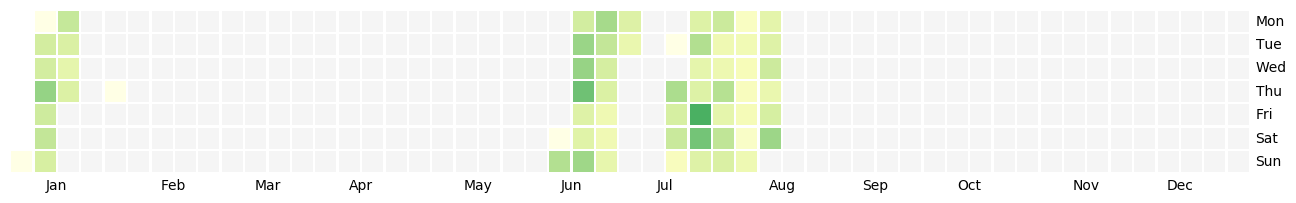

In [147]:
dailytotal.index = pd.to_datetime(dailytotal.index)

plt.rcParams['figure.figsize'] = 16, 8

#calmap has a futurewarning. 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

calmap.yearplot(data=dailytotal,year=2017,cmap='YlGn')

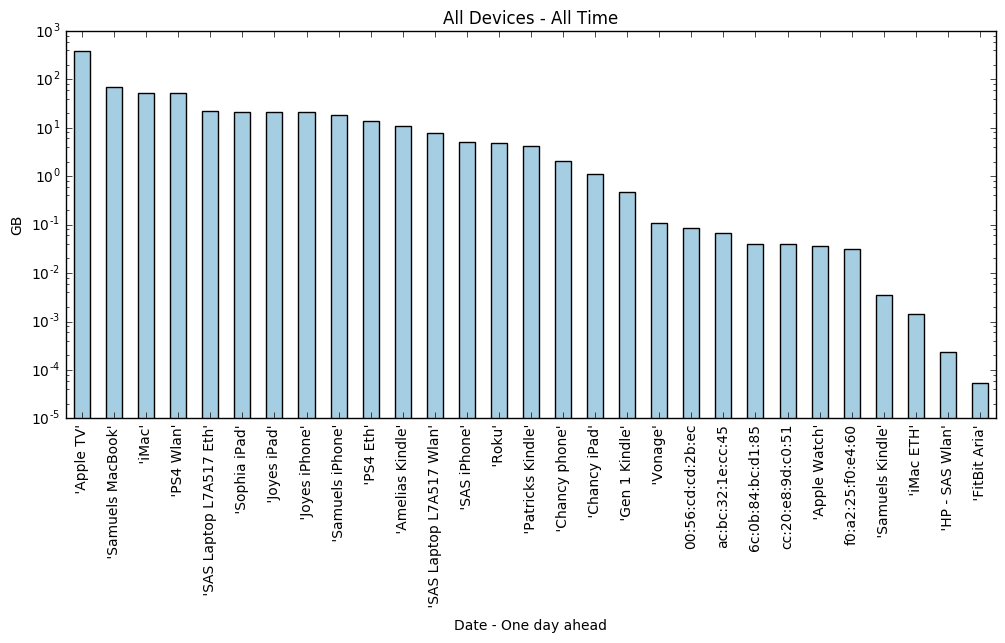

In [148]:
#df0 = devicetotal.unstack('devicename').fillna(0)
pp0 = devicetotal.sort_values(ascending=False).plot(kind='bar',stacked=False, colormap='Paired',figsize=(12, 5),logy=True)
pp0.set_xlabel('Date - One day ahead')
pp0.set_ylabel('GB')
pp0.set_title("All Devices - All Time")

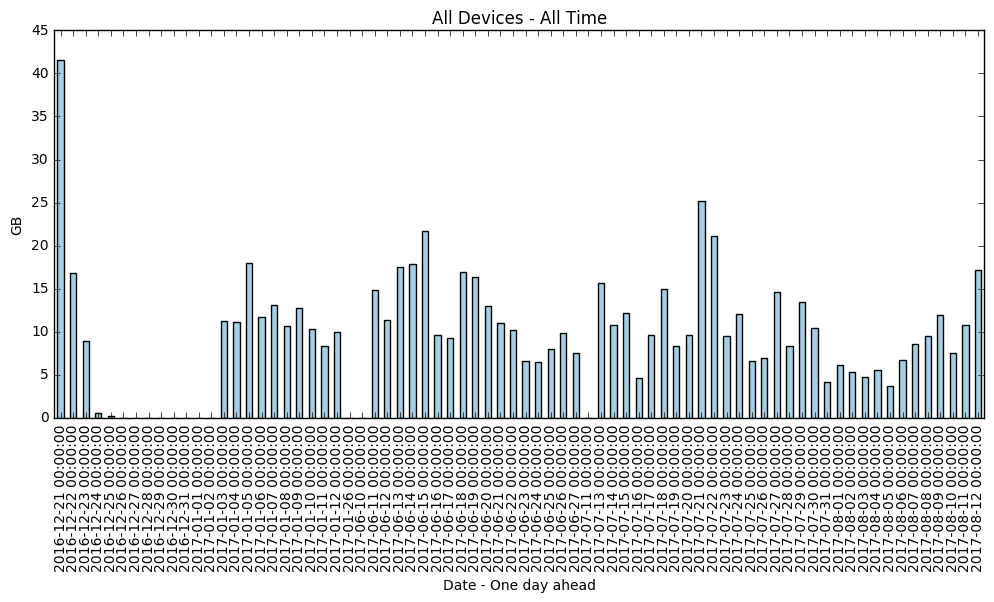

In [149]:
#df0 = devicetotal.unstack('devicename').fillna(0)
pp0 = dailytotal.plot(kind='bar',stacked=False, colormap='Paired',figsize=(12, 5))
pp0.set_xlabel('Date - One day ahead')
pp0.set_ylabel('GB')
pp0.set_title("All Devices - All Time")

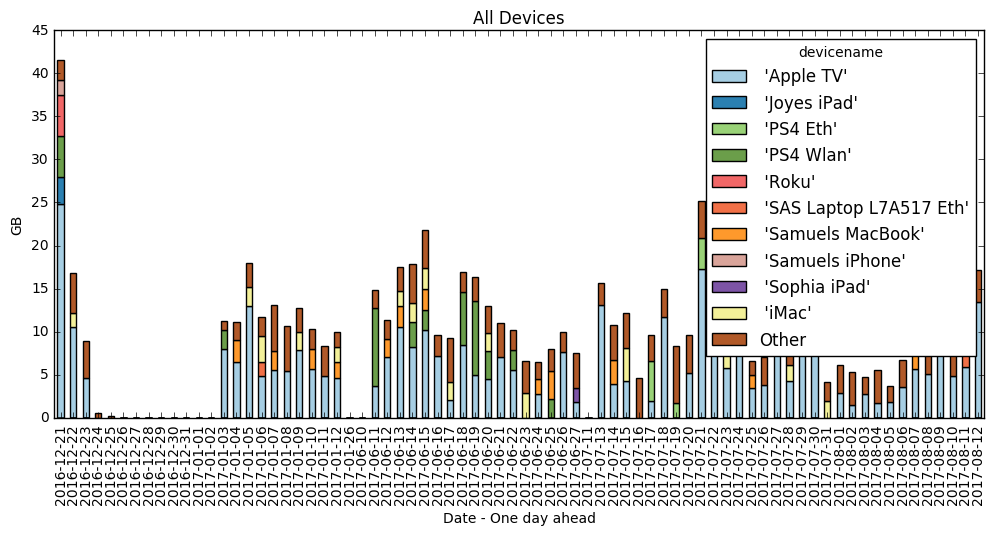

In [150]:
df2 = devicedaily.unstack('devicename').fillna(0)
pp2 = df2.plot(kind='bar',stacked=True, colormap='Paired',figsize=(12, 5))
pp2.set_xlabel('Date - One day ahead')
pp2.set_ylabel('GB')
pp2.set_title("All Devices")

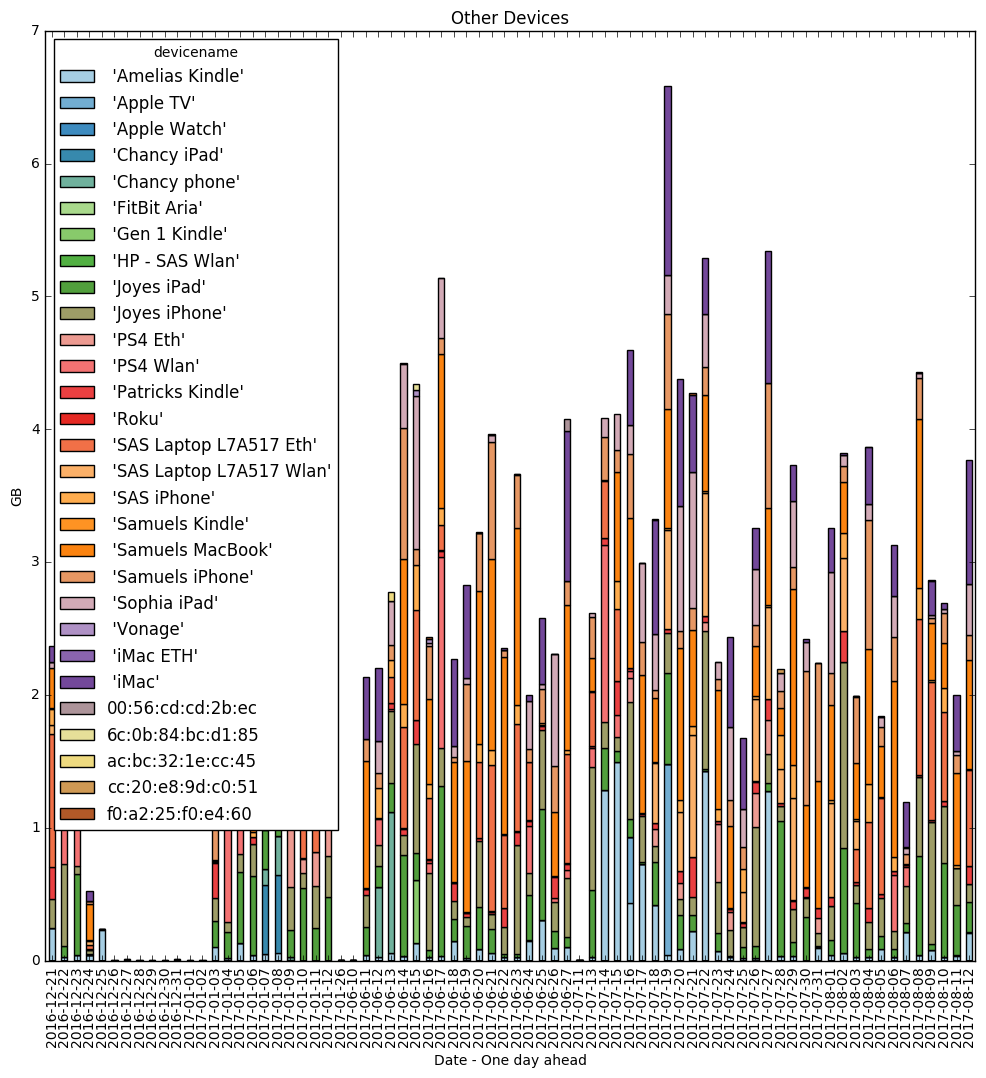

In [151]:
df3 = smalldaily.unstack('devicename').fillna(0)
pp3 = df3.plot(kind='bar',stacked=True, colormap='Paired',figsize=(12, 12))
pp3.set_xlabel('Date - One day ahead')
pp3.set_ylabel('GB')
pp3.set_title("Other Devices")